In [13]:
import os
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#To make the notebook's output stabel across runs
np.random.seed(42)

#Uses Jupyter's own backend to plot
%matplotlib inline

#To make pretty figures
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

#Path to saving images
IMAGE_PATH = os.path.join("images")
os.makedirs(IMAGE_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension ,dpi=resolution)

***Ensemble Learning*** is a technique where you take a group of predictors (such as classifiers and regressors) and you aggregate their predictions, which is most often better than an individual predictor.

A group of predictors is called an ***ensemble***<br>
An Ensemble Learning algorithm is called an ***Ensemble method***

An example of **Ensemble method**: train a group of Decision Tree classifiers, each on a different random subset of the training set. To make the predictions, you obtain the predictions of all the individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a ***Random Forest***, as simply as it may sound, it's one of the most powerful Machine Learning algorithms available today

**When should I use an Esemble method?**

It's often used near the end of a project, once a few good predictors have been built, combine them into an even better predictor

We will cover the most popular **Ensemble methods**, _bagging_, _boosting_ and _stacking_

# Section: Voting Classifiers

***Hard voting*** is when you aggregate the predictions of several classifiers and predict the class that get the most votes (a majority vote classifier)

This voting classifier often achieves a higher accuracy than the best calssifier in the ensemble. Even if each classifier is a ***weak learner*** (it does slightly better than random guessing), the ensemble can still be a ***strong learner*** (achieving high accuracy), provided there are a sufficent number of weak learners and they're sufficiently diverse

**Ensemble methods**  work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble's accuracy

Let's create and train a voting classifier (**hard voting**), composed of three diverse classifiers

<img src="images/Ensemble and RF - Hard voting classifier predictions.png">

In [2]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)


In [3]:
log_clf_hardv = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf_hardv = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf_hardv = SVC(gamma="scale", random_state=42)

voting_clf_hardv = VotingClassifier(
    estimators = [("lr", log_clf_hardv), ("rf", rnd_clf_hardv), 
                  ("svc", svm_clf_hardv)],
    voting = "hard"
)

In [4]:
voting_clf_hardv.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
for clf in (log_clf_hardv, rnd_clf_hardv, svm_clf_hardv, voting_clf_hardv):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.88
SVC 0.87
VotingClassifier 0.87


***Soft voting*** is when you predict the class with the highest class probabilty, averaged over all the individual classifiers. Assuming that all classifiers are able to estimate class probablities - they have the _predict_proba()_ method

It often achieves a higher performance than hard voting beause it gives more weight to highly confident votes

Let's create and train a voting classifier(**soft voting**), composed of three diverse classifiers

**Note** SVC doesn't have the _predict_proba()_ method by default, so we need to set _probability=True_ hyperparameter (this makes SVC use cross validation to estimate class probabilities, slowing down training), then it will add a _predict proba()_ method

In [6]:
log_clf_softv = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf_softv = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf_softv = SVC(gamma="scale", probability=True, random_state=42)

voting_clf_softv = VotingClassifier(
    estimators = [("lr", log_clf_softv), ("rf", rnd_clf_softv), 
                  ("svm", svm_clf_softv)],
    voting = "soft"
)
voting_clf_softv.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svm', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
for clf in (log_clf_softv, rnd_clf_softv, svm_clf_softv, voting_clf_softv):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.88
SVC 0.87
VotingClassifier 0.89


As we can see it achieved a higher accuracy, 89% (87% for **hard voting**)

# End Of Section: Voting Classifiers

# Section: Bagging And Pasting

We've just seen that in order to get a diverse set of classifiers, we need different algorithms. Another approach is to use the same training algorithm for every predictor (e.g classifier) and train them on different random subsets of the training set

When sampling is performed ***with replacement***, it's ***called bagging*** (short for bootstrap aggregating). When sampling is performed ***without replacement***, it's ***called pasting***

That is, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor

<img src="images/Ensemble and RF - Bagging and pasting on different random samples.png">

After all the classifiers are trained, the ensemble can make a prediction for a new instace by aggregating the predictions of all classifiers. The aggregation functions is typically **the _statistical mode_ (the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression.**

**Each individual predictor** has **a higher bias** than if it were trained on the original training set, but **aggregation reduces both bias and variance.** Generally, the net result is that the **ensemble has a similar bias but a lower variance than a single predictor**

Bagging and pasting **scale very well** - predictors can all be **trained and made in parallel**

##### Bagging and pasting in Scikit Learn

We'll create an ensemble of 500 Decision Tree classifiers: 
<ul>
    <li>Each is trained on 100 training instances randomly sampled for the training set with replacement (example of <strong>bagging</strong>, set <em>bootstrap=False</em> for <strong>pasting</strong>)</li>
    <li>The <em>n_jobs</em> indicates the number of CPU cores to use for training and predictions (-1 tells Scikit Learn to use all cores)</li>
</ul>

The _BagginClassifier_ automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (if it has _predict_proba()_), which is the case for with Decision Tree classifiers

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500, max_samples=100,
    n_jobs=-1, bootstrap=True, random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.82

We'll compare the decision boundaries of a single Decision Tree with that of a bagging ensemble of 500 trees. 

The folloing plot shows that the ensemble will most likely generalize better: it has a comparable bias but a smaller variance (it has roughly the same number of errors, but the decision boundary is less irregular)

In [20]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5,
                           contour=True):
    x1s = np.linspace(axes[0], axes[1], 100) 
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_map = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_map)
    if contour:
        custom_map2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, alpha=0.8, cmap=custom_map2)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=16)
    plt.ylabel(r"$x_2$", rotation=0, fontsize=16)


Saving figure Ensemble and RF - Decision tree vs bagging ensemble of 500 trees


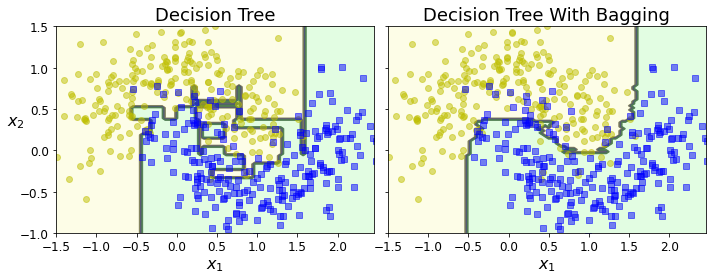

Figure 7-5


In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=18)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Tree With Bagging", fontsize=18)
plt.ylabel("")

save_fig("Ensemble and RF - Decision tree vs bagging ensemble of 500 trees")
plt.show()
print("Figure 7-5")

Bootstraping introduces a bit more diversity in the subsets that each predictor is trained on, thus bagging ends up with a slightly higher bias that pasting; but the extra diversity also means that the predictors end up being less correlated, to the ensemble's variance is reduced.

Overall, bagging results in better model. However, if you have spare time and CPU power, you can use cross validation to evaluate both bagging and pasting then select the one that works best

##### Out-of-bag evaluation